# LSTM vs. Transformers for Stock Price Prediction

---



> Question: Which model is better for predicting stock prices, using only previous stock price data, LSTM's or Transformers?

We will evaluate our models on several axis: First, prediction performance on the test data set. Second, the variance of our models predictions over the variance of the underlying test data. Third, the speed of training and inference, and lastly but related, the number of parameters in our model.

Evaluation Metrics:

For prediction performance: Mean Absolute Percentage Error (MAPE).
Specific implementation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html

For uncertainty: np.var('our predictions') / np.var('actual data')

For speed: seconds of runtime.
Specific implementation: https://docs.python.org/3/library/timeit.html

Implementation steps:

1. Set up our helper classes (`ETL`, `PredictAndForecast`, `Evaluate`). ✅
2. Implement an LSTM as a baseline.✅
3. Implement a transformer architecture for timeseries regression.✅
4. Train our models and use them for inference, measuring performance as we go.✅
5. Evaluate our models' performances against our test set. ✅
6. Visualize our predictions as a sanity check.✅

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import yfinance as yf

In [2]:
FILE_PATH = '../data/spy-etf.csv'


if os.path.exists(FILE_PATH):
    data = pd.read_csv(FILE_PATH)
else:
    data = yf.Ticker("SPY")
    data = data.history(period="max")
    data.to_csv(FILE_PATH)

In [3]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,24.840673,1003200
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.017349,480500
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.070351,201300
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.335371,529400
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.441372,531500
...,...,...,...,...,...,...,...
7775,2023-12-14,472.500000,473.730011,469.250000,472.010010,470.104004,119026000
7776,2023-12-15,469.489990,470.700012,467.429993,469.329987,469.329987,141319300
7777,2023-12-18,470.980011,472.980011,469.890015,471.970001,471.970001,70375300
7778,2023-12-19,472.529999,474.920013,472.450012,474.839996,474.839996,55761800


In [4]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1993-01-29,43.937500
1,1993-02-01,44.250000
2,1993-02-02,44.343750
3,1993-02-03,44.812500
4,1993-02-04,45.000000
...,...,...
7775,2023-12-14,472.010010
7776,2023-12-15,469.329987
7777,2023-12-18,471.970001
7778,2023-12-19,474.839996


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

/var/folders/5t/1wwb4x_d4hd53smqcd96d_500000gn/T/ipykernel_84776/1819287010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


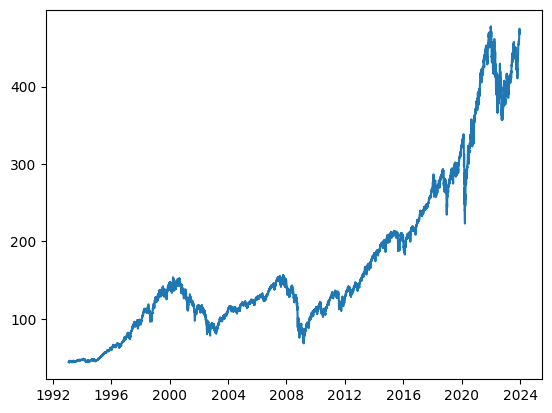

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [7]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1993-02-09,44.656250,44.968750,44.968750,45.000000,44.812500,44.343750,44.250000,43.937500
1993-02-10,44.718750,44.656250,44.968750,44.968750,45.000000,44.812500,44.343750,44.250000
1993-02-11,44.937500,44.718750,44.656250,44.968750,44.968750,45.000000,44.812500,44.343750
1993-02-12,44.593750,44.937500,44.718750,44.656250,44.968750,44.968750,45.000000,44.812500
1993-02-16,43.468750,44.593750,44.937500,44.718750,44.656250,44.968750,44.968750,45.000000
...,...,...,...,...,...,...,...,...
2023-12-14,472.010010,470.500000,464.100006,461.989990,460.200012,458.230011,454.760010,456.600006
2023-12-15,469.329987,472.010010,470.500000,464.100006,461.989990,460.200012,458.230011,454.760010
2023-12-18,471.970001,469.329987,472.010010,470.500000,464.100006,461.989990,460.200012,458.230011


In [8]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 44.65625   ,  44.96875   ,  44.96875   , ...,  44.34375   ,
         44.25      ,  43.9375    ],
       [ 44.71875   ,  44.65625   ,  44.96875   , ...,  44.8125    ,
         44.34375   ,  44.25      ],
       [ 44.9375    ,  44.71875   ,  44.65625   , ...,  45.        ,
         44.8125    ,  44.34375   ],
       ...,
       [471.97000122, 469.32998657, 472.01000977, ..., 461.98999023,
        460.20001221, 458.23001099],
       [474.83999634, 471.97000122, 469.32998657, ..., 464.1000061 ,
        461.98999023, 460.20001221],
       [468.26000977, 474.83999634, 471.97000122, ..., 470.5       ,
        464.1000061 , 461.98999023]])

In [9]:
shifted_df_as_np.shape

(7773, 8)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99424366, -0.99280457, -0.99280457, ..., -0.99568274,
        -0.99611447, -0.99755356],
       [-0.99395584, -0.99424366, -0.99280457, ..., -0.99352412,
        -0.99568274, -0.99611447],
       [-0.99294848, -0.99395584, -0.99424366, ..., -0.99266067,
        -0.99352412, -0.99568274],
       ...,
       [ 0.97356693,  0.96140947,  0.97375117, ...,  0.92760826,
         0.91936528,  0.91029329],
       [ 0.98678347,  0.97356693,  0.96140947, ...,  0.93732504,
         0.92760826,  0.91936528],
       [ 0.95648215,  0.98678347,  0.97356693, ...,  0.96679747,
         0.93732504,  0.92760826]])

In [11]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((7773, 7), (7773,))

In [12]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99755356, -0.99611447, -0.99568274, ..., -0.99266067,
        -0.99280457, -0.99280457],
       [-0.99611447, -0.99568274, -0.99352412, ..., -0.99280457,
        -0.99280457, -0.99424366],
       [-0.99568274, -0.99352412, -0.99266067, ..., -0.99280457,
        -0.99424366, -0.99395584],
       ...,
       [ 0.91029329,  0.91936528,  0.92760826, ...,  0.96679747,
         0.97375117,  0.96140947],
       [ 0.91936528,  0.92760826,  0.93732504, ...,  0.97375117,
         0.96140947,  0.97356693],
       [ 0.92760826,  0.93732504,  0.96679747, ...,  0.96140947,
         0.97356693,  0.98678347]])

In [13]:
split_index = int(len(X) * 0.95)

split_index

7384

In [14]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7384, 7), (389, 7), (7384,), (389,))

In [15]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7384, 7, 1), (389, 7, 1), (7384, 1), (389, 1))

In [16]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([7384, 7, 1]),
 torch.Size([389, 7, 1]),
 torch.Size([7384, 1]),
 torch.Size([389, 1]))

In [17]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [18]:
train_dataset

In [19]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 7, 1]) torch.Size([32, 1])


In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [22]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [23]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [24]:
# learning_rate = 0.001
num_epochs = 25
loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters())


for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.582
Batch 200, Loss: 0.201

Val Loss: 0.842
***************************************************

Epoch: 2
Batch 100, Loss: 0.065
Batch 200, Loss: 0.026

Val Loss: 0.215
***************************************************

Epoch: 3
Batch 100, Loss: 0.012
Batch 200, Loss: 0.009

Val Loss: 0.102
***************************************************

Epoch: 4
Batch 100, Loss: 0.006
Batch 200, Loss: 0.005

Val Loss: 0.039
***************************************************

Epoch: 5
Batch 100, Loss: 0.003
Batch 200, Loss: 0.002

Val Loss: 0.016
***************************************************

Epoch: 6
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001

Val Loss: 0.008
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.004
***************************************************

Epoch: 8
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.003
***************************************************



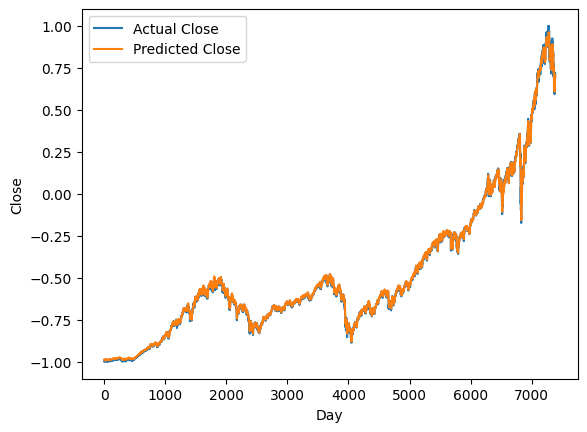

In [25]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [26]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 46.44464148,  46.39680319,  46.3476188 , ..., 411.53635744,
       411.8135503 , 414.39105818])

In [27]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 44.65624535,  44.71874835,  44.93750239, ..., 409.59000176,
       417.39001154, 410.54001116])

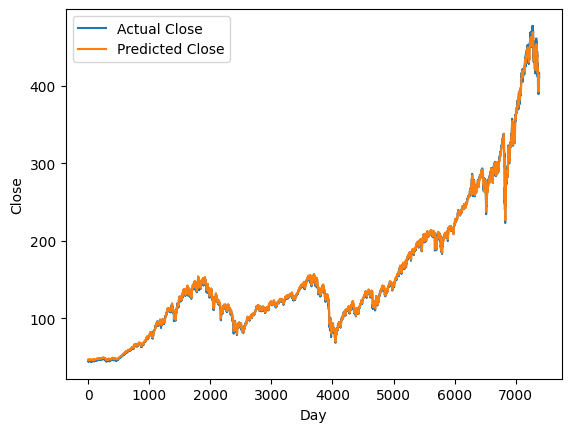

In [28]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [29]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([413.51846241, 413.06298908, 414.30643514, 413.56973066,
       408.98863201, 400.78180261, 388.89952741, 380.44194824,
       378.46402394, 373.62963863, 369.7574035 , 371.45778547,
       373.57123864, 376.5074172 , 383.31187024, 387.45172022,
       386.01763289, 383.74464109, 380.86932174, 380.83330065,
       381.79647335, 383.16035644, 386.37823211, 388.48795763,
       387.67113437, 385.09472667, 382.32052007, 380.29047326,
       382.35149329, 383.15816903, 387.66862337, 392.00376126,
       396.18412364, 397.03439228, 397.06539139, 394.95679194,
       397.47617163, 401.87113327, 407.24373817, 410.0373726 ,
       410.1400256 , 412.21316051, 413.59319679, 414.1197545 ,
       414.0732882 , 413.28215731, 416.08354475, 418.26751281,
       422.29579188, 425.53136099, 427.67706876, 427.61556239,
       427.72371627, 425.5629296 , 420.59407676, 416.7487895 ,
       415.0644054 , 416.76370013, 412.78175793, 408.48926809,
       403.87447812, 399.86969107, 398.14479457, 395.86

In [30]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([411.79000651, 415.7399918 , 411.21999828, 401.44000622,
       389.79999002, 375.00000629, 373.86999497, 379.20001654,
       366.64999208, 365.85998726, 375.07000344, 374.39001633,
       378.06000008, 390.07999156, 388.59000229, 380.6499982 ,
       380.33999418, 377.24999792, 381.23999082, 381.95998556,
       383.25000146, 388.98998786, 388.67001752, 384.23001334,
       380.82998717, 378.82998168, 377.91000063, 385.13000999,
       381.9500063 , 392.26999117, 394.76999481, 398.79000314,
       395.08999103, 395.57000477, 390.89001961, 401.04000771,
       406.07000451, 411.98999282, 410.76998701, 408.05999192,
       414.45001473, 414.17001318, 413.47000284, 412.9899891 ,
       411.35000038, 419.98998892, 419.98998892, 427.10000645,
       428.85997919, 429.70000972, 426.64999519, 427.89001128,
       422.14001975, 413.35000588, 412.3500096 , 413.67001504,
       419.51001401, 405.31000216, 402.63000955, 398.20998977,
       395.17999846, 396.42001455, 392.2399887 , 390.76

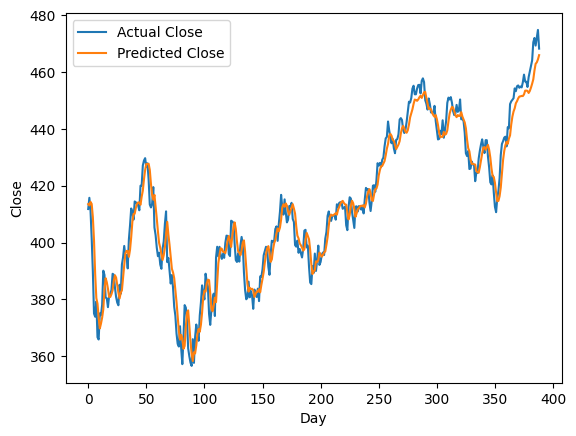

In [31]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [32]:
from sklearn.metrics import mean_absolute_percentage_error

class Evaluate:

  def __init__(self, actual, predictions) -> None:
    self.actual = actual
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

baseline_evals = Evaluate(new_y_test, test_predictions)
baseline_evals.mape, baseline_evals.var_ratio

(0.011438985396708075, 0.13494033071952993)